<a href="https://colab.research.google.com/github/M-Salim-I/Other-Projects/blob/main/Theory/KMeans_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import random
from collections import defaultdict # so it doesn't raise a KeyError

# Test Harness

For unit testing we test all the functions in our class which is for complete coverage, but for integration testing we test for certain functions defined in our class, to ensure the useful information from our algorithm is tested accordingly.

In [2]:
# unit test for my implementation
def unit_test_shortestDistance():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1)
    
    assert(KM.shortestDistance(pts[0], pts[1]) == 1)

def unit_test_init_centroids():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1)
    # shows reproducibility of results with random.seed
    assert(np.array_equal(KM.init_centroids(), KM.init_centroids()))

def unit_test_closest_centroid():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1) 
    
    assert(KM.closest_centroid(pts) == {(1.0,): [np.array([1])], 
                                           (2.0,): [np.array([2])], 
                                           (10.0,): [np.array([10])]})
    
def unit_test_implement_KMeans():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1) 
    KM.fit()

    assert(KM.implement_KMeans(1) == None)

def unit_test_fit():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1) 
    
    assert(KM.fit() == None)

def unit_test_total_var():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1) 
    KM.fit()
    
    assert(KM.total_var({(1.0,): [np.array([1])], 
                         (2.0,): [np.array([2])], 
                         (10.0,): [np.array([10])]}) == 0.0)
    
def unit_test_idx_lowest_var_cluster():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1)
    KM.fit()
    
    assert(KM.idx_lowest_var_cluster() == 0)

def unit_test_optimal_centroids():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1)
    KM.fit()
    
    assert(np.array_equal(KM.optimal_centroids(), (np.array([[1.], [2.], [10.]]))) == True)

def unit_test_optimal_cluster():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1)
    KM.fit()
    
    assert(KM.optimal_cluster() == {(1.0,): [np.array([1])], 
                                    (2.0,): [np.array([2])], 
                                    (10.0,): [np.array([10])]})
    
def unit_test_final_labels():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1)
    KM.fit()
    
    assert(np.array_equal(KM.final_labels(), np.array([0, 1, 2])))

def unit_tests():
    unit_test_shortestDistance()
    unit_test_init_centroids()
    unit_test_closest_centroid()
    unit_test_implement_KMeans()
    unit_test_fit()
    unit_test_total_var()
    unit_test_idx_lowest_var_cluster()
    unit_test_optimal_centroids()
    unit_test_optimal_cluster()
    unit_test_final_labels()

In [3]:
# integration test for my implementation
def integration_tests():
    pts = np.array([[1], [2], [10]])
    KM = KMeans(dataset = pts, n_clusters = 3, n_centroid_inits = 1)
    KM.fit()
    
    assert(np.array_equal(KM.optimal_centroids(), (np.array([[1.], [2.], [10.]]))) == True)
    assert(KM.optimal_cluster() == {(1.0,): [np.array([1])], 
                                    (2.0,): [np.array([2])], 
                                    (10.0,): [np.array([10])]})
    assert(np.array_equal(KM.final_labels(), np.array([0, 1, 2])))

# Implement k-means clustering in Python

Implementation inspired and adapted from: https://dfrieds.com/machine-learning/k-means-from-scratch-python.html

In [4]:
class KMeans(object):
    
    """
    Algorithm is under unsupervised learning where the dataset is unlabeled 
    (i.e. data without defined categories or groups). 
    
    This is an algorithm that tries to partition a dataset consiting of 
    n-dimensional data points into K pre-defined distinct non-overlapping 
    subgroups (clusters) where each data point belongs to only one cluster.
    """
    
    def __init__(self, dataset, n_clusters, n_centroid_inits,
                 max_iter = 300):
        
        """
        Attributes
        ----------
        dataset: numpy.ndarray
            A numpy array of n-dimensional points you'd like to cluster
        n_clusters: int
            number of clusters to create, cannot be a negative number, 
            zero, or more than the number of data points
        n_centroid_inits: int
            number of centrod initializations
        max_iter: int
            maximum number of possible iterations to run K-Means
            
        Methods
        -------
        shortestDistance(X0, X1)
            finds the euclidean distance between 2 n dimensional points in space
            
        init_centroids()
            assigns inital centroids to the dataset by picking those centroids at random
            
        closest_centroid(centroids)
            assigns each point in the dataset to its closest centroid
            
        implement_KMeans(init_n)
            
        fit()
            We fit the algorithm to our dataset in order to be able to
            output the optimal clusters, and optimal cluster assignments
            after our algorithm has terminated
            
        total_var(clusters)
            finds the variation in each cluster by using 
            the sum of squared distances of dataset points to their cluster centers
            
        idx_lowest_var_cluster()
            finds the index with the minimum varation value 
            in the list containing the variation values
            
        optimal_cluster()
            finds the centroids of the optimal cluster and 
            assigns each point based on the lowest variation value
            
        optimal_centroids()
            gets centroids of the optimal cluster assignment 
            based on the lowest variance value # fix
        
        final_labels(self):
            We get the optimal labels for each data point in our data set.
        """
        
        self.dataset = dataset
        self.n_clusters = n_clusters
        
        # self.dataset.shape gives a tuple (x, y) 
        # corresponding to the number of rows (x) and the number of columns (y)
        # rows are the number of points, columns are the nummber of variables in the dataset
        self.n_pts, self.n_variables = self.dataset.shape
        self.n_centroid_inits = n_centroid_inits
        
        # list of the amount of varitation within each cluster
        self.var_values = []
        # the number of iterations the algorithm will carry out 
        # and then stop after the last iteration
        self.max_iter = max_iter
        
        # all centroids and clustered dataset points
        self.clusters_all_iter_record = []

    @staticmethod
    def shortestDistance(X0, X1):
        
        """
        We us a static method to compute the euclidean distance 
        between 2 n-dimensional points in space
        
        Formula:
    
        X0 = (a1, ..., an), X1 = (b1, ..., bn)
    
        ||X0 - X1|| = sqrt((a1 - b1) **2 + ... + (an - bn) **2)
        
        Parameters
        ----------
    
        X0 : numpy.ndarray
             An n-dimensional coordinate in space
     
        X1 : numpy.ndarray
             An n-dimensional coordinate in space
     
        Returns 
        -------
    
        float
            The euclidean distance between the 2 n-dimensional numpy arrays 
            which gives a scalar value
        """
        
        # Using the Linear Algebra definition of the norm, 
        # we can find the distance between two n-dimensional points
        return np.linalg.norm(X0 - X1)

    def init_centroids(self):
        
        """
        We create random initial centroids based on the dataset; 
        the number of centroids we create initially will
        depend on the number of clusters we input for our dataset.
        
        Returns
        -------
        init_centroids: numpy.ndarray
                gives the initial centroids in the dataset
        """
        
        # We do this in order to produce reproducible results
        random.seed(0)
        
        # randomly pick k numbers that is between 0 and the number of rows in the array
        dataset_idxs = random.sample(range(0, self.n_pts), self.n_clusters)
        
        # the numbers given in the random_dataset_idxs are then 
        # used to index the intial centroids in the dataset
        init_centroids = self.dataset[dataset_idxs]
        
        return init_centroids

    def closest_centroid(self, centroids):
        
        """
        Given a number of centroid values, we assign each point in the dataset 
        to its closest centroid based on the  euclidean distance metric 
        (by using the shortestDistance function). 
        We use result_after_single_iter to know what the centroid 
        and its associated points are in a single iteration.
        
        Parameters
        ----------
        
        centroids: numpy.ndarray 
                   An array consisting of the centroids
                   
        Returns
        -------
        each_iter_result: dict
                   records of centroid and associated dataset points in its cluster 
                   for a single K-Means iteration
        """
        
        # create an empty dictionary to store the data points 
        # as values with the centroids as its key
        each_iter_result = defaultdict(list)
        
        for point in self.dataset:
            # stores the distances between each point and the centroids
            dists = []
        
            for centroid in centroids:
                
                dists.append(self.shortestDistance(centroid, point))
                
            # finds the centroid that is the closest to a certain point
            idx_of_closest_centroid = np.argmin(dists)
            closest_centroid = tuple(centroids[idx_of_closest_centroid])
            each_iter_result[closest_centroid].append(point)
            
        return dict(each_iter_result)

    def implement_KMeans(self, init_n):
        
        """
        We assign dataset points to clusters based on which centroid it is closest to. 
        We then update the centroids based on mean of cluster points.
        We then repeat the steps above until centroids don't move 
        i.e. the mean stays the same,
        or we've reached max number of iterations.
        
        Parameters
        ----------
        
        init_n: int
                number of points at the start which are the centroids in the algorithm
        
        Returns
        -------
        
        None
        """
        
        centroids = self.init_centroids()
        # list of record of iteration centroids and clustered points
        self.clusters_all_iter_record.append([])
        # ensures algorithm is complete at this iteration, else will terminate
        for iteration in range(1, self.max_iter + 1):
            
            each_cluster_iter_record = self.closest_centroid(centroids = centroids)
            self.clusters_all_iter_record[init_n].append(each_cluster_iter_record)
            updated_centroids = []
            
            for centroid in each_cluster_iter_record:
                
                cluster_pts = each_cluster_iter_record[centroid]
                # finds the mean of each cluster
                updated_centroid = np.mean(cluster_pts, axis=0)
                # stores this mean in the new centroid list
                updated_centroids.append(updated_centroid)
            
            if self.shortestDistance(np.array(updated_centroids), centroids) == 0:
                
                # exits out of the for loop when the algorithm is finished, 
                # i.e. the assignments to each centroid for each data set point doesn't change
                # so the mean of each cluster has reached its optimal value
                break
                
            centroids = updated_centroids
            
        return None

    def fit(self):
        
        """
        Implements KMeans with max number of centroid initializations we input.
        
        Returns
        -------
        
        None
        """
        
        for init_n in range(self.n_centroid_inits):
            
            self.implement_KMeans(init_n = init_n)
            
            # the last index is the last cluster assignment of the iteration
            last_var_cluster_record = self.total_var(
                self.clusters_all_iter_record[init_n][-1]
            )
            self.var_values.append(last_var_cluster_record)
            
        return None

    def total_var(self, clusters):
        
        """
        Gets the sum of squared distances of dataset points 
        to their cluster centers for all clusters
        
        Parameters
        ----------
        
        clusters: dict
                  A dictionary of the clusters of the dataset 
        
        Returns
        -------
        
        each_cluster_total_variation: float
                finds how much variance there is in each cluster
                
        """
        
        each_cluster_variation = []
        
        # accesses the centroids (keys) and the points associated to the cluster (values)
        for centroid, cluster_pts in clusters.items():
            
            # iterates through each point for each cluster
            for cluster_point in cluster_pts:
                
                # finds the distance between the centroid and its associated points for each cluster
                # squared distances to avoid negative distances, then gets the total
                distance_squared = np.square(self.shortestDistance(cluster_point, centroid))
                each_cluster_variation.append(distance_squared)
        
        each_cluster_total_variation = np.sum(each_cluster_variation)
        
        return each_cluster_total_variation

    def idx_lowest_var_cluster(self):
        
        """
        In our list of variance_values, we find the index in the list 
        with minimum variance value
        
        Returns
        -------
        idx_lowest_var: int
                we find the index of the list that gives the smallest variance
        """
        # finds the index with smallest variance
        idx_lowest_var = np.argmin(self.var_values)
        
        return idx_lowest_var

    def optimal_cluster(self):
        
        """
        Get results of optimal cluster assignment 
        based  on the lowest variance value
        
        Return
        ------
        best_cluster: dict
            A dictionary with keys as centroids and 
            values as list of dataset points in the clusters
        """
        
        # we index the last element which is the final iteration with the lowest total variation value
        best_cluster = dict(self.clusters_all_iter_record[self.idx_lowest_var_cluster()][-1])
        
        return best_cluster

    def optimal_centroids(self):
        
        """
        We get the optimal centroids from the optimal cluster assignment. 
        This is done by using the smallest variance for each cluster.
        
        Return
        ------
        
        final_centroids: numpy.ndarray
                    An array where each row is the optimal centroid 
                    for each cluster after the algorithm terminates.
        """
        # gives the optimal centroids for each cluster
        final_centroids = np.array(list(self.optimal_cluster().keys()))
    
        return final_centroids
    
    def final_labels(self):
        
        """
        We get the optimal labels for each data point in our data set.
        
        Return
        ------
        
        optimal_labels: numpy.ndarray
            An array that returns the optimal labels for each data point starting from the number 0
            as needed to compare with the sklearn package
        """
        
        # create a list comprehension to be able to assign each value 
        # in the dictionary which is a cluster point
        # to the cluster number it was assigned to.
        optimal_labels = np.array(
            [idx for idx, arr in enumerate(self.optimal_cluster().values(), 0) for _ in arr]
        )
        
        return optimal_labels

Describing limitations and assumptions of your implementation:

K-Means assumes:

+ the variance of the distribution of each attribute (variable) is spherical;
+ all variables have the same variance;
+ the prior probability for all k clusters are the same, i.e. each cluster has roughly equal number of observations.
+ my implementation only accepts data sets that are in numpy arrays with pairs of x and y values.
+ It also assumes that the algorithm will terminate at or before 300.iterations if the number of iterations is not specified.

Limitations of K-Means:

+ The user has to specify k (the number of clusters) in the beginning
+ K-Means can only handle numerical data.
+ K-Means assumes that we deal with spherical clusters and that each cluster has roughly equal numbers of observations.
+ K-Means is a lazy learner where generalization of the training data is delayed until a query is made to the system.
+ K-Means has trouble clustering data where clusters are of varying sizes and density.
+ Being dependent on initial values so might not return the best solution.
+ Clustering outliers if they are present in your dataset
+ Scaling with number of dimensions.
+ My implementatiton does not work with pandas data frames where potential data sets may be stored.

Description of the complexity of your algorithm:

+ Time complexity of the algorithm = O(number of data points * number of clusters * number of features in data * number of iterations of the algorithm).
+ For well structured data, generally the algorithm converges (terminates) very quickly.

# Visualising KMeans

In [5]:
def plot_clusters(clusters, x_label = "x", y_label = "y", title = "Result"):
        
        """
        plots final cluster assignments if we only have 1 or 2 variables from our dataset
        Can't plot in higher dimensions, hard to visualize so 1D or 2D
         
        Parameters
        ----------
        
        clusters: dict
                  dictionary with centroids as keys and values as a 
                  list of dataset points in that cluster
         
        x_label: str
                label of the x axis of the graph
                
        y_label: str
                label of the y-axis of the graph
        
        title: str
                the title of the graph
        
        Return
        ------
        
        None
        """
        # if our points are 1 dimensional then we carry out the if statement below and 
        # turn it into 2 dimensional with the value of zero to the added dimension
        if len(list(clusters.keys())[0]) == 1:
            new = {}
            for k,v in clusters.items():
                if len(k) == 1:
                    v = [np.append(ar, [0]) for ar in v]
                    new[k+(0,)] = v
                else:
                    break

            clusters = new
        
        # plotting the figure of the graph
        plt.figure(figsize=(20,10))
        # stores colours
        colors = ['lime', 'cyan', 'black', 'saddlebrown', 'gold', 'orange',
                         'red', 'darkorchid', 'darkolivegreen',  'blue', 'deeppink', 'grey']
        
        # initialize the first cluster to be darkred and the label of the first cluster as 1
        color_idx = 0
        # this we can do but keep in mind for our above algorithm cluster labelling starts at 0 
        # so here we say cluster label 0 for cluster 1
        cluster_n = 0
        
        # use for loop to plot each cluster with the centroid alongside 
        # with the dataset points in the dictionary
        for centroid, cluster_pts in clusters.items():
            
            cluster_color = colors[color_idx]
            x_vals_idx = 0
            y_vals_idx = 1
            
            # plotting the centroid of each cluster with a transparent colour
            plt.scatter(centroid[x_vals_idx], centroid[y_vals_idx], 
                        color = cluster_color, s = 900, marker = "*", alpha = 0.25, linewidth = 7,
                        label = " Centroid of cluster " + str(cluster_n))

            cluster_pts_x_vals = []
            cluster_pts_y_vals = []
            # unpacks clusters that are (x, y) pairs and stores them separately in 2 lists
            for cluster_point in cluster_pts:
                
                cluster_pts_x_vals.append(cluster_point[x_vals_idx])
            
            for cluster_point in cluster_pts:
                
                cluster_pts_y_vals.append(cluster_point[y_vals_idx])
            
            # plotting the points of each cluster and with the same colour 
            # as its centroid but in a full colour
            plt.scatter(cluster_pts_x_vals, cluster_pts_y_vals, 
                        color = cluster_color, s = 180, marker = 'o', 
                        label = "Cluster " + str(cluster_n))
            
            # increment so the new cluster has a different colour 
            # and label than to the previous one
            cluster_n += 1
            color_idx += 1
            
        # adding labels to the graph
        plt.title(title, fontsize = 25)
        plt.xlabel(x_label, fontsize = 25)
        plt.ylabel(y_label, fontsize = 25)
        plt.legend(loc = "best", fontsize = 15)
        plt.grid()
        
        plt.show()
        
        return None

# Testing Implementation

In [6]:
unit_tests()
integration_tests()

In [7]:
pts1D = np.array([[1], [2], [10]])
KM = KMeans(dataset = pts1D, n_clusters = 3, n_centroid_inits = 1)
KM.fit()

optimal_centroids = KM.optimal_centroids()
print("optimal centroids: \n", optimal_centroids)
optimal_cluster_assignment = KM.optimal_cluster()
print("optimal cluster assignment: \n", optimal_cluster_assignment)
labels = KM.final_labels()
print("optimal labels: \n", labels)

optimal centroids: 
 [[ 1.]
 [ 2.]
 [10.]]
optimal cluster assignment: 
 {(1.0,): [array([1])], (2.0,): [array([2])], (10.0,): [array([10])]}
optimal labels: 
 [0 1 2]


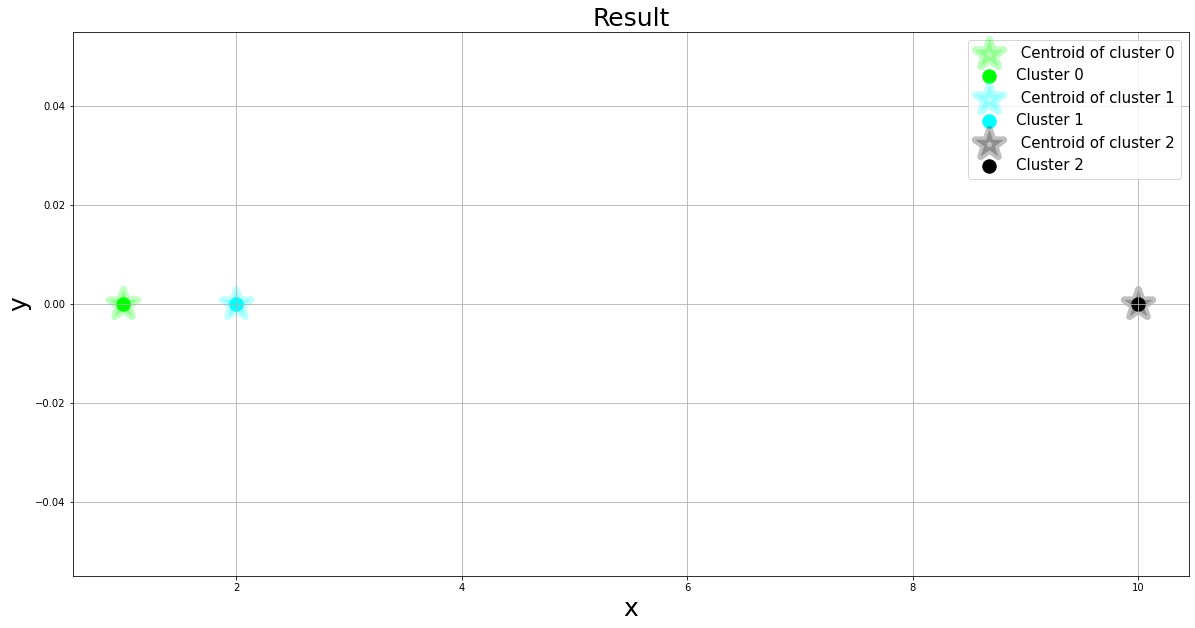

In [8]:
plot_clusters(optimal_cluster_assignment, x_label = "x", y_label = "y", title = "Result")

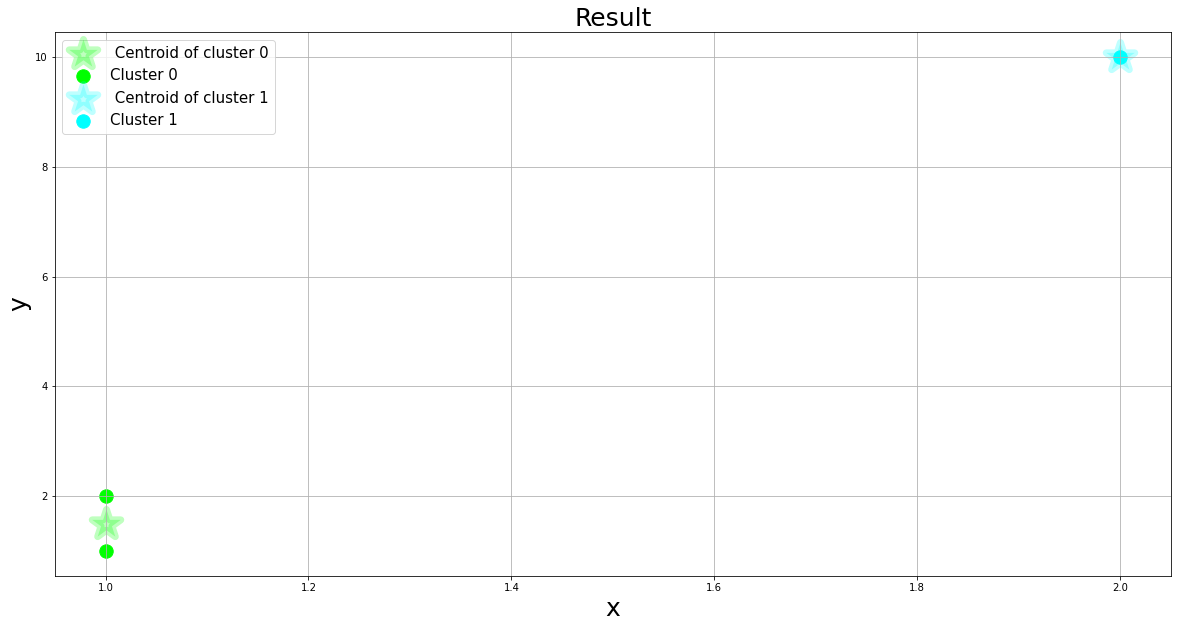

In [9]:
pts2D = np.array([[1, 1], [1, 2], [2, 10]])
KM = KMeans(dataset = pts2D, n_clusters = 2, n_centroid_inits = 1)
KM.fit()

optimal_centroids = KM.optimal_centroids()
optimal_cluster_assignment = KM.optimal_cluster()
labels = KM.final_labels()

plot_clusters(optimal_cluster_assignment, x_label = "x", y_label = "y", title = "Result")